In [ ]:
# Import third party modules
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models

from sklearn.model_selection import train_test_split
from tqdm import tqdm
import shap
import pandas as pd
import numpy as np
import random

# For visualisations
shap.initjs()
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [ ]:
# Remove 'Consider rewriting this model with the Functional API' warnings from Tensorflow
# These warnings can be ignored: https://github.com/tensorflow/recommenders/issues/188
tf.get_logger().setLevel('ERROR')

In [ ]:
# Import custom modules
from metrics.sensitivity import calculate_sensitivity
from metrics.infidelity import calculate_infidelity

from model.metadata import get_feature_names, get_feature_names_of_type, append_indices, append_baselines
from model.feature_columns import get_normalization_parameters, create_numeric_columns, create_categorical_columns
from model.dataset_converter import convert_df_dataset, convert_dataframe_numpy, convert_numpy_tensor


## Validating the metrics

1) Run multiple times, with fresh model runs. Do we get consistent results?
2) Consider the end points. Do these tend to a sensible value i.e. one or zero? 
3) Build simple linear models (as desribed below).
4) Test with Iris dataset to see if values are sensible. 
5) Sense check with bank marketing dataset - duration included vs not included

Meaningful endpoints - tend to zero or one? 
Think about comparisons between datasets. If scaling arbitrarily, means is dependent on dataset. 
Could use Iris dataset? As known relationships between features/output. 

#### Fidelity

* Set up a simple dataset with x1, x2 and y. 
* Output of y = x1 (or is clearly related in some way). x2 bears no relation to the output of y: it is just noise. 
* Manually set up two 'explanations' e1 and e2 with the most salient features being x1 and x2 respectively (we can use the actual explanation for e1, and use this to baseline e2). 
* We would expect e1 to have higher fidelity / lower infidelity. This is because: adjusting the output with higher explanation value will have bigger impact for e1, and lower (theoretically none for e2).
* Can try different variants of this (e.g. where x2 is loosely related to y) to see if that nudges the fidelity metric the right way. 
* _Sensitivity doesn't really work for this - due to the fake explanation (the explanation would change completely for e2)._

#### Sensitivity

* Build a model representing a piecewise function with discontinuities. Sensitivity should be higher for instances around the discountinuities. 

### 1) Multiple runs

Conclusion: sensitivities appear to vary somewhat arbitrarily. This may be due to different model configurations. 

Fidelities for explanations with similar salient features are similar. This is encouraging. 

It will be interesting to run this for a larger sample and compare fidelities and sensitivities. 

Iris dataset will be useful for further validating - this is a weakly correlated, unbalanced dataset, and so model outputs can look quite different between fittings. 

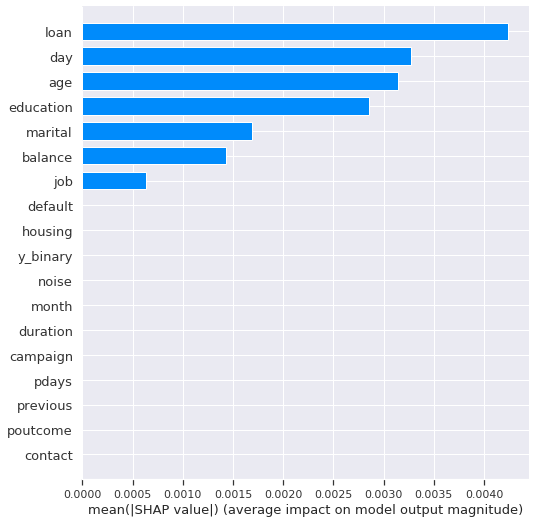

In [37]:
models = []
outputs = []
shap_values = []
sensitivities = []
infidelities = []
for index in range (1):
    
    # Build model
    metrics_test_model, _ = create_fit_model(train_ds, input_layer, METRICS, epochs=10, verbose=0)
    models.append(metrics_test_model)
    
    # Get model output
    metrics_test_instance = convert_dataframe_numpy(dataframe, index_to_explain)
    metrics_test_output = predict_wrapper(metrics_test_model, metrics_test_instance, feature_names)
    outputs.append(metrics_test_output)
    
    # Generate explanation
    metrics_test_predictor = shap_predictor_factory(feature_names, metrics_test_model)
    metrics_test_explainer = get_explainer(metrics_test_predictor, dataframe)
    metrics_test_shap_values = generate_explanation(metrics_test_explainer, dataframe, index_to_explain, metrics_test_model, chart=True, feature_names=feature_names)
    shap_values.append(metrics_test_shap_values)
    
    # Generate metrics
#     metrics_test_explainer_simple = simple_explainer_factory(metrics_test_explainer)
#     metrics_test_sensitivity = calculate_sensitivity(metrics_test_explainer_simple, metrics_test_shap_values, metrics_test_instance[0], metadata)
#     sensitivities.append(metrics_test_sensitivity)
    metrics_test_infidelity_model = fidelity_model_factory(metrics_test_model, feature_names)
    metrics_test_infidelity = calculate_infidelity(metrics_test_shap_values[0], metrics_test_infidelity_model, metrics_test_instance[0], metadata)
    infidelities.append(metrics_test_infidelity)

In [38]:
models, outputs, shap_values, sensitivities, infidelities

([<tensorflow.python.keras.engine.sequential.Sequential at 0x7fcd183a4bb0>],
 [array([[0.01390475]], dtype=float32)],
 [[array([-0.00314112,  0.00063373, -0.00168694,  0.0028554 ,  0.        ,
           0.00143404,  0.        , -0.00423543,  0.        ,  0.00327792,
           0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
           0.        ,  0.        ,  0.        ])]],
 [],
 [array([[0.08257461]], dtype=float32)])

#### 2) Consider end points

Sensitivity: this is just the L2 difference between two vectors (representing the two explanations). So the minimum is zero, with no theoretical maximum.

Fidelity: there is no maximum or minimum value. Can be negative or positive. It is not clear what zero actually represents. Maybe some room for improvement here? Note that Yeh. et al never get a negative value - have I implemented/understood maths correctly? 


#### 3) Linear models

In [4]:
class MockLinearModel:
    def __init__(self, x1_ratio, x2_ratio):
        self.x1_ratio = x1_ratio
        self.x2_ratio = x2_ratio
    
    def predict(self, input):
        # 2D array is to replicate the TF return format
        return (input[0] * self.x1_ratio + input[1] * self.x2_ratio)
    
mock_linear_metadata = [
    {
        'name': 'x1',
        'type': 'numerical',
        'baseline': 0.5
    },
    {
        'name': 'x2',
        'type': 'numerical',
        'baseline': 0.5
    }
]


In [5]:
mock_linear_results = pd.DataFrame(columns=['variable', 'value', 'infidelity'])
example_instance = [2, 6] # x1, x2
explanation_inputs = np.linspace(-2, 2, 21)

for value in explanation_inputs:
    mock_linear_model = MockLinearModel(value, 0)
    mock_explanation = [2, 0]
    mock_linear_infidelity = calculate_infidelity(mock_explanation, mock_linear_model, example_instance, mock_linear_metadata, num_baselined_features=1)
    print(value, mock_linear_infidelity)

---------------------------------------
instance_original [2, 6]
instance_perturbed [0.5, 6]
first part 6.0
second part 9.0
-2.0 0.6666666666666666
---------------------------------------
instance_original [2, 6]
instance_perturbed [0.5, 6]
first part 6.0
second part 7.290000000000001
-1.8 0.8230452674897119
---------------------------------------
instance_original [2, 6]
instance_perturbed [0.5, 6]
first part 6.0
second part 5.760000000000002
-1.6 1.0416666666666663
---------------------------------------
instance_original [2, 6]
instance_perturbed [0.5, 6]
first part 6.0
second part 4.409999999999998
-1.4 1.3605442176870752
---------------------------------------
instance_original [2, 6]
instance_perturbed [0.5, 6]
first part 6.0
second part 3.2399999999999993
-1.2 1.8518518518518523
---------------------------------------
instance_original [2, 6]
instance_perturbed [0.5, 6]
first part 6.0
second part 2.25
-1.0 2.6666666666666665
---------------------------------------
instance_origi

divide by zero encountered in double_scalars


In [4]:
input_length = 2
reference = np.zeros(input_length)

stepwise_instance = np.array([1, 3])

mock_linear_metadata = [
    {
        'name': 'x1',
        'type': 'numerical',
        'used': True,
        'index': 0,
        'baseline': 1
    },
    {
        'name': 'x2',
        'type': 'numerical',
        'used': True,
        'index': 1,
        'baseline': 1
    }
]

# Discontinuities at x0 = 0  and x0 = 2
def stepwise_linear(inputs):
    output = np.array([])
    for inp in inputs:
        if inp[0] < 0:
            output = np.append(output, inp[1])
        elif inp[0] >= 0 and inp[0] < 2:
            output = np.append(output, inp[1] + 3)
        elif inp[0] >= 2:
            output = np.append(output, inp[1] + 6)
    return output
        
stepwise_explainer = shap.KernelExplainer(stepwise_linear, np.reshape(reference, (1, len(reference))))

FIXED_VARIABLE_VALUE = 1
stepwise_sensitivies = pd.DataFrame(columns=['variable', 'input_value', 'output_value'])
stepwise_inputs = np.linspace(-2, 4, 61)

for x0_input in stepwise_inputs:
    stepwise_input = np.array([x0_input, FIXED_VARIABLE_VALUE])
    stepwise_shap_values = stepwise_explainer.shap_values(stepwise_input)
    stepwise_linear_sensitivity = calculate_sensitivity(stepwise_explainer.shap_values, stepwise_shap_values, stepwise_input, mock_linear_metadata)
    stepwise_sensitivies = stepwise_sensitivies.append({
        'variable': 'x0',
        'input_value': x0_input,
        'output_value': stepwise_linear_sensitivity
    }, ignore_index=True)
    
for x1_input in stepwise_inputs:
    stepwise_input = np.array([FIXED_VARIABLE_VALUE, x1_input])
    stepwise_shap_values = stepwise_explainer.shap_values(stepwise_input)
    stepwise_linear_sensitivity = calculate_sensitivity(stepwise_explainer.shap_values, stepwise_shap_values, stepwise_input, mock_linear_metadata)
    stepwise_sensitivies = stepwise_sensitivies.append({
        'variable': 'x1',
        'input_value': x1_input,
        'output_value': stepwise_linear_sensitivity
    }, ignore_index=True)

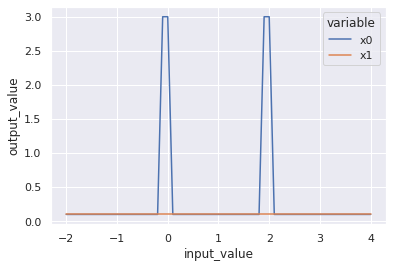

In [5]:
sns.lineplot(data=stepwise_sensitivies, x="input_value", y="output_value", hue="variable")

### Overfitted model

Approach - try building models with 5 - 50 epochs (multiples of 5), with and without dropout. Compare metrics on TEST as well as training set. 

Hypothesis - models with higher epochs, and without dropout, will have higher accuracy on the training set but lower on test set. 

In [62]:
overfitting_results = pd.DataFrame(columns=['dropout', 'epochs', 'train_loss', 'train_accuracy', 'train_auc', 'test_loss', 'test_accuracy', 'test_auc'])


In [63]:
# With dropout
tf.get_logger().setLevel('ERROR')
for epochs in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 40, 50]:
    print(f'Calculating epoch: {epochs}')
    
    # With dropout
    model_with_dropout, history_with_dropout = create_fit_model(train_ds, input_layer, METRICS, epochs=epochs, dropout=True, verbose=0)
    test_loss, test_accuracy, test_precision, test_recall, test_auc = model_with_dropout.evaluate(test_ds)
    overfitting_results = overfitting_results.append({
        'dropout': True,
        'epochs': epochs,
        'train_loss': history_with_dropout.history['loss'][-1],
        'train_accuracy': history_with_dropout.history['accuracy'][-1],
        'train_auc': history_with_dropout.history['auc'][-1],
        'test_loss': test_loss,
        'test_accuracy': test_accuracy,
        'test_auc': test_auc
    }, ignore_index=True)
    
    # Without dropout
    model_without_dropout, history_without_dropout = create_fit_model(train_ds, input_layer, METRICS, epochs=epochs, dropout=False, verbose=0)
    test_loss, test_accuracy, test_precision, test_recall, test_auc = model_without_dropout.evaluate(test_ds)
    overfitting_results = overfitting_results.append({
        'dropout': False,
        'epochs': epochs,
        'train_loss': history_without_dropout.history['loss'][-1],
        'train_accuracy': history_without_dropout.history['accuracy'][-1],
        'train_auc': history_without_dropout.history['auc'][-1],
        'test_loss': test_loss,
        'test_accuracy': test_accuracy,
        'test_auc': test_auc
    }, ignore_index=True)


Calculating epoch: 1
91/91 [==============================] - 1s 5ms/step - loss: 0.2938 - accuracy: 0.8917 - precision: 0.6246 - recall: 0.2088 - auc: 0.7906
Calculating epoch: 2
91/91 [==============================] - 1s 5ms/step - loss: 0.2927 - accuracy: 0.8882 - precision: 0.5462 - recall: 0.3155 - auc: 0.7911
Calculating epoch: 3
91/91 [==============================] - 1s 5ms/step - loss: 0.2912 - accuracy: 0.8907 - precision: 0.5717 - recall: 0.2987 - auc: 0.7940
Calculating epoch: 4
91/91 [==============================] - 2s 7ms/step - loss: 0.2937 - accuracy: 0.8914 - precision: 0.5915 - recall: 0.2603 - auc: 0.7902
Calculating epoch: 5
91/91 [==============================] - 1s 5ms/step - loss: 0.2906 - accuracy: 0.8907 - precision: 0.5862 - recall: 0.2547 - auc: 0.7944
Calculating epoch: 6
91/91 [==============================] - 1s 5ms/step - loss: 0.2991 - accuracy: 0.8876 - precision: 0.5439 - recall: 0.3015 - auc: 0.7896
Calculating epoch: 7
91/91 [==================

In [64]:
overfitting_results

,dropout,epochs,train_loss,train_accuracy,train_auc,test_loss,test_accuracy,test_auc
0,True,1,0.321270,0.830448,0.719060,0.297430,0.893398,0.785512
1,False,1,0.313512,0.887815,0.755049,0.293771,0.891739,0.790568
2,True,2,0.298255,0.892833,0.772010,0.294068,0.892956,0.790837
3,False,2,0.289854,0.893442,0.789919,0.292658,0.888201,0.791140
4,True,3,0.292650,0.893027,0.785712,0.292476,0.890965,0.789249
5,False,3,0.284758,0.895598,0.799935,0.291155,0.890744,0.794025
6,True,4,0.287514,0.895101,0.796318,0.292295,0.890965,0.793562
7,False,4,0.279499,0.897534,0.810426,0.293729,0.891408,0.790192
8,True,5,0.283317,0.895958,0.804912,0.295180,0.892292,0.785340
9,False,5,0.274944,0.898087,0.819175,0.290631,0.890744,0.794396


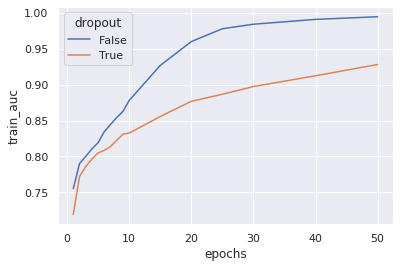

In [68]:
sns.lineplot(data=overfitting_results, x="epochs", y="train_auc", hue="dropout")

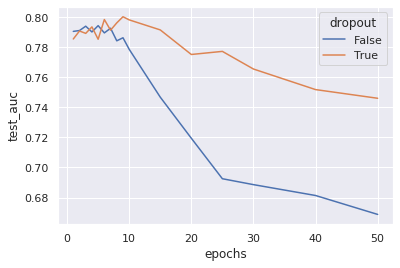

In [69]:
sns.lineplot(data=overfitting_results, x="epochs", y="test_auc", hue="dropout")

### Formal Verification

Sigmoid in output layer won't work without some sort of hack. 

If all we want is the class and not the probability, we can just use an argmax (>/< 0.5).

In [37]:
np.linalg.norm(np.array([[[1,2,3]]]) - np.array([[[4,5,6]]]))

5.196152422706632